In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
ts_df = pd.read_csv('/Users/nuthankumar/Downloads/Time-Series-Forecasting-using-Deep-Learning-main/Chapter 03/uk_temperature_prediction/data/MET_Office_Weather_Data.csv')

In [3]:
ts = ts_df.loc[ts_df["station"]=='sheffield']

In [4]:
ts.head()

,year,month,tmax,tmin,af,rain,sun,station
26161,1883.0,1.0,6.3,1.7,6.0,122.1,NaN,sheffield
26162,1883.0,2.0,8.0,2.8,2.0,69.8,NaN,sheffield
26163,1883.0,3.0,4.8,-1.6,23.0,29.6,NaN,sheffield
26164,1883.0,4.0,12.2,3.8,2.0,74.0,NaN,sheffield
26165,1883.0,5.0,14.7,6.2,0.0,31.2,NaN,sheffield


In [5]:
ts.describe().T 

,count,mean,std,min,25%,50%,75%,max
year,1650.0,1951.250909,39.705390,1883.0,1917.000,1951.00,1986.000,2020.0
month,1650.0,6.489091,3.453082,1.0,3.000,6.00,9.000,12.0
tmax,1623.0,12.886014,5.347162,-0.6,8.200,12.70,17.700,25.6
tmin,1623.0,6.224892,4.042961,-4.2,2.900,5.70,10.000,14.5
af,1623.0,2.896488,4.848672,0.0,0.000,0.00,4.000,28.0
rain,1648.0,66.685680,38.147088,0.6,39.275,60.05,87.450,285.6
sun,1088.0,111.450368,61.229335,5.8,55.675,107.10,157.475,290.8


In [6]:
ts.isna().sum()

year         0
month        0
tmax        27
tmin        27
af          27
rain         2
sun        562
station      0
dtype: int64

In [7]:
ts = ts_df.loc[ts_df["station"]=='sheffield']['tmin'].interpolate().dropna().tolist()

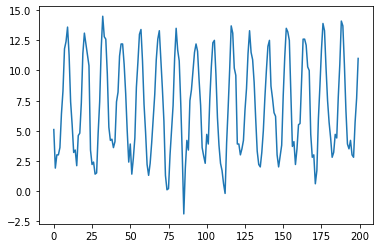

In [8]:
plt.plot(ts[-200:])

In [9]:
import torch 
import torch.nn.functional as F 

In [10]:
class DL(torch.nn.Module):
    def __init__(self, n_inp, l_1, l_2, conv1_out, conv1_kernel, conv2_kernel, drop1=0):
        super(DL, self).__init__()
        conv1_out_ch = conv1_out
        conv2_out_ch = conv1_out * 2
        conv1_kernel = conv1_kernel
        conv2_kernel = conv2_kernel
        self.dropout_lin1 = drop1
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=conv1_out_ch, kernel_size=conv1_kernel, padding= conv1_kernel-1)
        self.conv2 = torch.nn.Conv1d(in_channels=conv1_out_ch, out_channels=conv2_out_ch, kernel_size=conv2_kernel, padding=conv2_kernel-1)

        feature_tensor = self.feature_stack(torch.Tensor([[0]*n_inp]))
        self.lin1 = torch.nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2,1)
        
    def feature_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim=1)
        return x

    def fc_stack(self, x):
        x1 = F.relu(self.lin1(x))
        # x1 = F.relu(self.dropout_lin1)
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y 

    def forward(self,x):
        x = self.feature_stack(x)
        y = self.fc_stack(x)
        return y 

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch

class SarimaxPredictor(torch.nn.Module):
    def forward(self,x):
        last_values = []
        l = x.tolist()
        counter = 0

        for r in l:
            model = SARIMAX(r, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
            results = model.fit(disp=0)
            forecast = results.forecast()
            last_values.append([forecast[0]])
            counter =+ 1
            print(f'debug: SARIM CALCLATION {counter}/{len(l)}')

        return torch.tensor(data = last_values)

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
class HwesPredictor(torch.nn.Module):
    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r, trend = None, seasonal = 'add', seasonal_periods=12)
            result = model.fit()
            forecast = result.forecast()
            last_values.append([forecast[0]])
        return torch.tensor(data = last_values)

In [13]:
def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y

In [14]:
def get_training_datasets(features, test_len, ts):
    ts = ts 
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len], \
                                       Y[0:-test_len], \
                                       X[-test_len:], \
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [15]:
import copy 
import random
import sys

random.seed(1)
torch.manual_seed(1)

features = 120 

x_train, x_val, x_test, y_train, y_val, y_test = \
    get_training_datasets(features, 60, ts =ts )

In [16]:
net = DL(
    n_inp = features,
    l_1 = 400,
    l_2 = 48,
    conv1_out = 6,
    conv1_kernel = 36,
    conv2_kernel = 12,
    drop1 = 0.1,
) 
net.train()

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


DL(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 6, kernel_size=(36,), stride=(1,), padding=(35,))
  (conv2): Conv1d(6, 12, kernel_size=(12,), stride=(1,), padding=(11,))
  (lin1): Linear(in_features=528, out_features=400, bias=True)
  (lin2): Linear(in_features=400, out_features=48, bias=True)
  (lin3): Linear(in_features=48, out_features=1, bias=True)
)

In [17]:
sarima_predictor = SarimaxPredictor()
hwes_predictor = HwesPredictor()

In [18]:


optimizer = torch.optim.Adam(params=net.parameters())
abs_loss = torch.nn.L1Loss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(150):

    prediction = net(x_train)
    loss = abs_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction = net(x_val)
    val_loss = abs_loss(val_prediction, y_val)
    
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()

    if t % 10 ==0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')
            


epoch 0: train - 6.1618, val: - 6.2501
epoch 10: train - 2.5729, val: - 2.4723
epoch 20: train - 1.1912, val: - 1.5448
epoch 30: train - 1.0331, val: - 0.9457
epoch 40: train - 1.0222, val: - 0.9314
epoch 50: train - 0.9975, val: - 0.9982
epoch 60: train - 0.979, val: - 0.949
epoch 70: train - 0.9667, val: - 0.955
epoch 80: train - 0.9588, val: - 0.9626
epoch 90: train - 0.9499, val: - 0.9571
epoch 100: train - 0.9405, val: - 0.9584
epoch 110: train - 0.9308, val: - 0.9623
epoch 120: train - 0.9184, val: - 0.9669
epoch 130: train - 0.9072, val: - 0.9538
epoch 140: train - 0.8903, val: - 0.9741


In [19]:
dl_prediction = best_model(x_test)
sarima_prediction = sarima_predictor(x_test)
hwes_prediction = hwes_predictor(x_test)

dl_abs_loss = round(abs_loss(dl_prediction, y_test).item(), 4)
sarima_abs_loss = round(abs_loss(sarima_prediction, y_test).item(), 4)
hwes_abs_loss = round(abs_loss(hwes_prediction, y_test).item(), 4)

print('===')
print('Results on Test Dataset')
print(f'DL Loss: {dl_abs_loss}')
print(f'SARIMA Loss: {sarima_abs_loss}')
print(f'HWES Loss: {hwes_abs_loss}')

debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM C

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


===
Results on Test Dataset
DL Loss: 0.8569
SARIMA Loss: 0.9227
HWES Loss: 1.0464


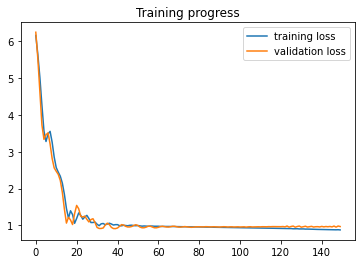

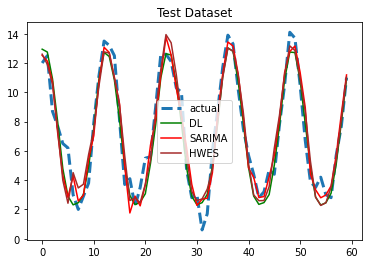

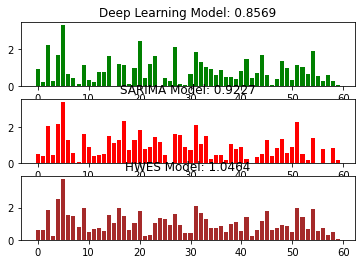

In [20]:
plt.title("Training progress")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()

plt.title('Test Dataset')
plt.plot(y_test, '--', label = 'actual', linewidth = 3)
plt.plot(best_model(x_test).tolist(), label = 'DL', color = 'g')
plt.plot(sarima_prediction.tolist(), label = 'SARIMA', color = 'r')
plt.plot(hwes_prediction.tolist(), label = 'HWES', color = 'brown')
plt.legend()
plt.show()

test_n = len(y_test)
dl_abs_dev = (dl_prediction - y_test).abs_()
sarima_abs_dev = (sarima_prediction - y_test).abs_()
hwes_abs_dev = (hwes_prediction - y_test).abs_()

fig = plt.figure()

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.set_title(f'Deep Learning Model: {dl_abs_loss}')
ax1.bar(list(range(test_n)), dl_abs_dev.view(test_n).tolist(), color = 'g')

ax2.set_title(f'SARIMA Model: {sarima_abs_loss}')
ax2.bar(list(range(test_n)), sarima_abs_dev.view(test_n).tolist(), color = 'r')

ax3.set_title(f'HWES Model: {hwes_abs_loss}')
ax3.bar(list(range(test_n)), hwes_abs_dev.view(test_n).tolist(), color = 'brown')

plt.show()